# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [309]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
#!kaggle datasets download -d khaledzsa/traffic-dataset
#!unzip traffic-dataset.zip

In [310]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers,Input
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import zscore
import datetime
from sklearn.preprocessing import MinMaxScaler

In [311]:
df=pd.read_csv("/content/Traffic Data.csv",parse_dates=["date_time"],index_col="date_time")
df.sort_index(inplace=True)
df

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist
...,...,...,...,...,...,...,...
2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,Clouds,broken clouds
2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,Clouds,overcast clouds
2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

In [312]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)

<Axes: xlabel='traffic_volume', ylabel='Count'>

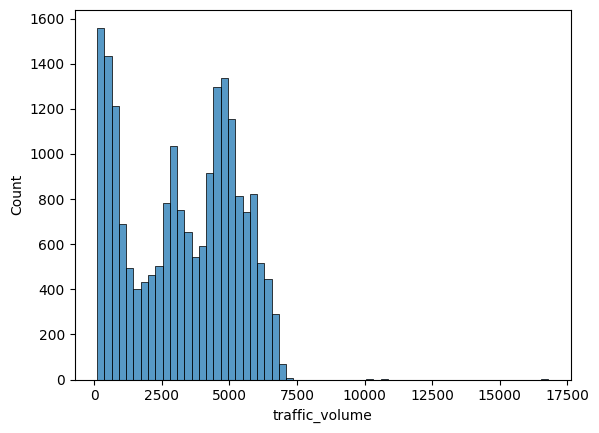

In [313]:
sns.histplot(data=df,x="traffic_volume")

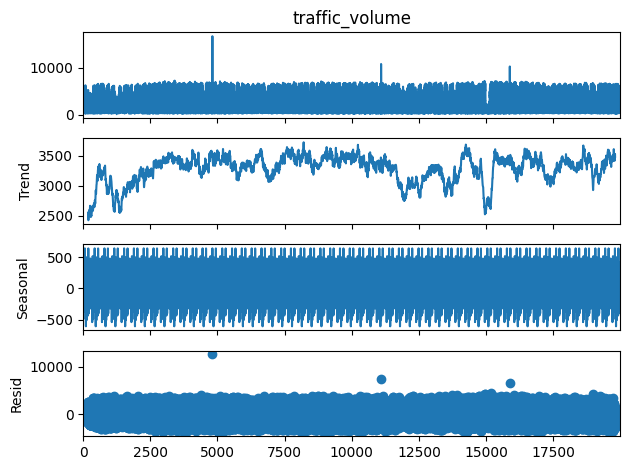

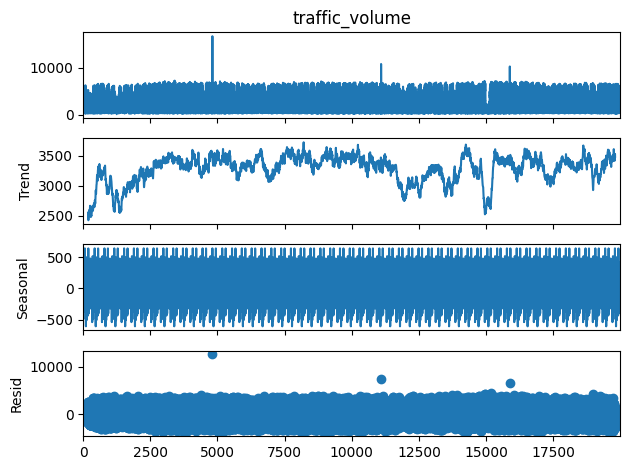

In [314]:
seasonal = seasonal_decompose(df["traffic_volume"].dropna(),period=(365))
seasonal.plot()

<Axes: >

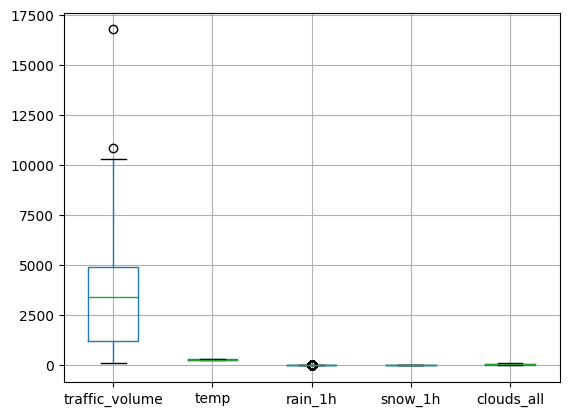

In [315]:
# we can see that there are outliers in traffic_volume and they are mostly impossible so we remove them
df.boxplot()

In [316]:
df.select_dtypes(include=np.number).describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19962.000000,19982.000000,19982.000000,19982.0,19982.000000
mean,3278.150636,281.163971,0.048439,0.0,49.391002
std,1977.085411,12.661165,0.398183,0.0,39.644539
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1229.250000,271.950000,0.000000,0.0,1.000000
50%,3428.000000,281.830000,0.000000,0.0,75.000000
75%,4928.000000,291.837500,0.000000,0.0,90.000000
max,16781.000000,310.070000,10.600000,0.0,92.000000


In [317]:
#Since the nulls are in the target we cant impute them so we are only left with drop the rows
df.isna().sum()


,0
date_time,0
traffic_volume,20
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [318]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19982 entries, 0 to 19981
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_time            19982 non-null  datetime64[ns]
 1   traffic_volume       19962 non-null  float64       
 2   temp                 19982 non-null  float64       
 3   rain_1h              19982 non-null  float64       
 4   snow_1h              19982 non-null  float64       
 5   clouds_all           19982 non-null  int64         
 6   weather_main         19982 non-null  object        
 7   weather_description  19982 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 1.2+ MB


## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [319]:
# some of the points mentioned above are done in the EDA process to enable the visuals to be correct

In [320]:
df=df.dropna()

In [321]:
df.isna().sum()

,0
date_time,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0


In [322]:
num_cols=df.select_dtypes(include=np.number).columns
num_cols

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all'], dtype='object')

In [323]:
df

,date_time,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow
1,2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2,2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist
3,2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog
4,2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist
...,...,...,...,...,...,...,...,...
19977,2018-09-30 19:00:00,3543.0,283.45,0.0,0.0,75,Clouds,broken clouds
19978,2018-09-30 20:00:00,2781.0,282.76,0.0,0.0,90,Clouds,overcast clouds
19979,2018-09-30 21:00:00,2159.0,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm
19980,2018-09-30 22:00:00,1450.0,282.09,0.0,0.0,90,Clouds,overcast clouds


In [324]:
df=df[abs(zscore(df["traffic_volume"]))<3]

In [325]:
df.select_dtypes(include=np.number).describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,19959.000000,19959.000000,19959.000000,19959.0,19959.000000
mean,3276.742823,281.159646,0.048495,0.0,49.405231
std,1973.568484,12.662313,0.398409,0.0,39.640898
min,113.000000,243.390000,0.000000,0.0,0.000000
25%,1229.000000,271.950000,0.000000,0.0,1.000000
50%,3427.000000,281.830000,0.000000,0.0,75.000000
75%,4927.000000,291.825000,0.000000,0.0,90.000000
max,7280.000000,310.070000,10.600000,0.0,92.000000


In [326]:
df.select_dtypes(include=np.number).corr()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
traffic_volume,1.000000,0.131832,0.012923,NaN,0.095059
temp,0.131832,1.000000,0.100380,NaN,-0.032400
rain_1h,0.012923,0.100380,1.000000,NaN,0.074954
snow_1h,NaN,NaN,NaN,NaN,NaN
clouds_all,0.095059,-0.032400,0.074954,NaN,1.000000


## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [327]:
df.head()

,date_time,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
0,2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow
1,2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2,2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist
3,2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog
4,2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist


In [328]:
df["prev_traffic_volume"]=df["traffic_volume"].shift(periods=1,fill_value=0)
df["diff_btw_traffic_volumes"]=df["traffic_volume"]-df["prev_traffic_volume"]
df["day_of_week"]=df["date_time"].dt.day_of_week
df["Month"]=df["date_time"].dt.month
df["Day_of_year"]=df["date_time"].dt.day_of_year

<ipython-input-328-8ff8af1e38ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["prev_traffic_volume"]=df["traffic_volume"].shift(periods=1,fill_value=0)
<ipython-input-328-8ff8af1e38ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["diff_btw_traffic_volumes"]=df["traffic_volume"]-df["prev_traffic_volume"]
<ipython-input-328-8ff8af1e38ab>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [329]:
df.head()

,date_time,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume,diff_btw_traffic_volumes,day_of_week,Month,Day_of_year
0,2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Snow,heavy snow,0.0,4872.0,4,11,323
1,2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog,4872.0,0.0,4,11,323
2,2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Mist,mist,4872.0,0.0,4,11,323
3,2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Fog,fog,4872.0,202.0,4,11,323
4,2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist,5074.0,0.0,4,11,323


## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [330]:
len(df)

19959

In [331]:
x_size=int(len(df)*0.8)
x_size
x=df["traffic_volume"]

In [332]:
gap=15
x_t,x_v=[],[]
for i in range(gap,len(x[:x_size])):
  x_t.append(x.iloc[i-gap])
  x_v.append(x.iloc[i])
print(f"x end at {i-gap} and have {len(x_t)} values.\n y end at {i} and have {len(x_v)} values.")

x end at 15951 and have 15952 values.
 y end at 15966 and have 15952 values.


In [333]:
gap=15
y_t,y_v=[],[]
for i in range(gap,len(x[x_size:])):
  y_t.append(x.iloc[i-gap])
  y_v.append(x.iloc[i])
print(f"x end at {i-gap} and have {len(y_t)} values.\n y end at {i} and have {len(y_v)} values.")

x end at 3976 and have 3977 values.
 y end at 3991 and have 3977 values.


## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [334]:
x.shape

(19959,)

In [360]:
x_t_reshape=np.reshape(x_t,(-1,1))
x_v_reshape=np.reshape(x_v,(-1,1))
scaler = MinMaxScaler()
sx_t=scaler.fit_transform(x_t_reshape)
sx_v=scaler.transform(x_v_reshape)
y_t_reshape=np.reshape(y_t,(-1,1))
y_v_reshape=np.reshape(y_v,(-1,1))
sy_t=scaler.transform(y_t_reshape)
sy_v=scaler.transform(y_v_reshape)
sx_t.shape

(15952, 1)

## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

In [353]:
model=Sequential()
model.add(Input(shape=(x.shape[0],1)))
model.add(layers.LSTM(units=10,seed=1))
model.add(layers.Dropout(0.15))
model.add(layers.Dense(units=1))

In [354]:
model.compile(optimizer="adam",loss="mse")

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

In [358]:
model.fit(sx_t,sx_v,epochs=5,batch_size=32)

Epoch 1/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0656
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0643
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0655
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0635
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0632


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [364]:
pred=model.predict(sy_t)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [378]:
model.evaluate(sy_t,sy_v)


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3845


0.3845479190349579

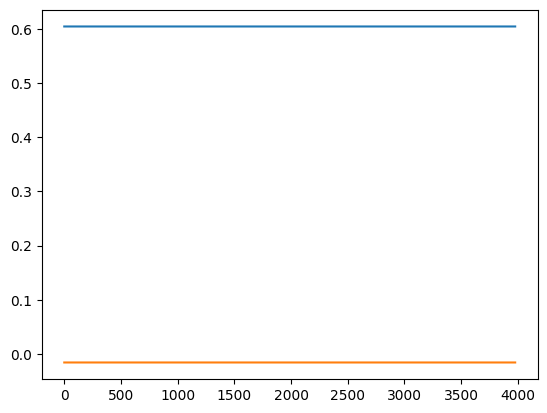

In [379]:
plt.plot(pred)
plt.plot(sy_t)

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

In [385]:
model1=Sequential()
model1.add(Input(shape=(x.shape[0],1)))
model1.add(layers.SimpleRNN(units=10,seed=1))
model1.add(layers.Dropout(0.15))
model1.add(layers.Dense(units=1))

In [386]:
model1.compile(optimizer="adam",loss="mse")

In [387]:
model1.fit(sx_t,sx_v,epochs=5,batch_size=32)

Epoch 1/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1547
Epoch 2/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0775
Epoch 3/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0721
Epoch 4/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0681
Epoch 5/5
499/499 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0686


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [388]:
pred=model1.predict(sy_t)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [389]:
model1.evaluate(sy_t,sy_v)

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3665  


0.36654284596443176

## Project Questions:

1. **Data Preprocessing**: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:
1- i removed the duplicated rows also i removed the null values since they were on the target column and i we cannot impute it
2-i added the prev hour's volume traffic and another column finding the diff between the prev and current one, also the day of the week , day of year and month.
